# iCAT import
---

#### Overview
The purpose of this notebook is to facilitate and guide in the creation of `render-ws` stacks. These stacks are made up of metadata regarding a collection of image tiles such as the geometric bounds, number of tiles and sections, resolution, etc. Each image tile in a stack has its own respective metadata as well, called a [tile specification](https://render-python.readthedocs.io/en/latest/guide/index.html#making-a-new-stack). Using [`pandas`](https://pandas.pydata.org/) and the [`icatapi`](https://github.com/lanery/iCAT-workflow/tree/master/icatapi), this notebook creates these tile specifications from image metadata, gathers them into stacks, and uploads the stacks to a local `render-ws` server.

#### Naming conventions
Within the context of the iCAT workflow, a collection of images from a single data source (e.g. individual fluorescence channel) is referred to as a "tileset". The collection of multiple data sources across an individual section is referred to as a "layer", while a "stack" is the collection of the same individual data source across multiple sections. A "project" is then a collection of multiple stacks.

-            | 1 section | > 1 section
------------ | --------- | -----------
\> 1 channel | layer     | project (or stacks)
1 channel    | tileset   | stack


#### Heirarchy
When building up `DataFrame`s of tile specifications, it is often necessary to group the data by stack or section. To try to stick to a convention, the sorting order is in general `stack` followed by `z` (or `sectionId`).


#### [TileSpec](https://github.com/fcollman/render-python/blob/master/renderapi/tilespec.py#L17) parameters

| Field    | Type     | Default | Description                                |
| -----    | ----     | ------- | -----------                                |
| tileId   | str      | None    | Unique string specifying a tile's identity |
| z        | float    | None    | z values this tile exists within           |
| width    | int      | None    | Width in pixels of the raw tile            |
| height   | int      | None    | Height in pixels of the raw tile           |
| imageUrl | str      | None    | An image path URI                          |
| maskUrl  | str      | None    | An image path for an alpha mask            |
| minint   | int      | 0       | Pixel intensity value to display as black  |
| maxint   | int      | 65535   | Pixel intensity value to display as white  |
| layout   | `Layout` | None    | a `Layout` object for this tile            |
| tforms   | list     | [ ]     | Transform objects                          |


#### [Layout](https://github.com/fcollman/render-python/blob/master/renderapi/layout.py#L1) parameters

| Field     | Type  | Default | Description                                  |
| -----     | ----  | ------- | -----------                                  |
| sectionId | str   | None    | sectionId this tile was taken from           |
| scopeId   | str   | None    | What microscope this came from               |
| cameraId  | str   | None    | Camera this was taken with                   |
| imageRow  | int   | None    | Row from a row,col layout this was taken     |
| imageCol  | int   | None    | Column from a row,col layout this was taken  |
| stageX    | float | None    | X stage coordinates for where this was taken |
| stageY    | float | None    | Y stage coordinates for where this was taken |
| rotation  | float | None    | Angle of camera when this was taken          |
| pixelsize | float | None    | Effective size of pixels                     |

#### Packages

In [1]:
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

#### Settings

In [2]:
# pandas display settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 20)

# Indirectly enable autocomplete
%config Completer.use_jedi = False

# Set matplotlib colormap
plt.set_cmap('magma')
plt.close();

## Set up environment
---

In [3]:
# `render` project parameters
# ---------------------------
owner = 'rlane'
project = 'pancreas'

# Data directories
# ----------------
project_dir = Path(f'/long_term_storage/{owner}/{project}')
stack_dirs = list(project_dir.glob('[!_]*'))

# Additional parameters
# ---------------------
section_thickness = 100  # nm

# Infer section and stack names
# -----------------------------
sectionIds = np.unique([[fp.name for fp in list(stack_dir.iterdir())] \
                                 for stack_dir in stack_dirs]).tolist()
stacks = np.unique([fp.name for fp in stack_dirs]).tolist()
stacks_EM = [stack for stack in stacks if 'EM' in stack]
stacks_FM = [stack for stack in stacks if 'EM' not in stack]

out = f"""\
sections..... {sectionIds}
all stacks... {stacks}
"""
print(out)

sections..... ['S004', 'S005', 'S006', 'S007']
all stacks... ['AF594', 'EM_himag', 'EM_lomag', 'Hoechst']



### Create `render-ws` instance

In [4]:
import renderapi

In [5]:
# Create a renderapi.connect.Render object
# ----------------------------------------
render_connect_params = {
    'host': 'sonic.tnw.tudelft.nl',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}
render = renderapi.connect(**render_connect_params)
render.make_kwargs()

{'host': 'http://sonic.tnw.tudelft.nl',
 'port': 8080,
 'owner': 'rlane',
 'project': 'pancreas',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'memGB': '2G'}

## Build up image tile DataFrame
---

In [6]:
from icatapi.importo import parse_metadata

In [7]:
# Collect tile specifications
tile_dicts = []

# Iterate through stack and section directories
for fp_stack in tqdm(stack_dirs):
    stack = fp_stack.name  # set stack name
    for fp_section in fp_stack.iterdir():
        sectionId = fp_section.name  # set section ID

        # Iterate through tile data
        fps_tiles = list(fp_section.glob('*.tif'))
        for i, fp_tile in enumerate(fps_tiles):

            # Parse tif file metadata
            tile_dict = parse_metadata(fp_tile, sectionId)

            # Set rotation angle
            z = tile_dict['z']
            tile_dict['stack'] = stack
            tile_dict['sectionId'] = sectionId
            tile_dicts.append(tile_dict)

# Build DataFrame
df_tiles = pd.DataFrame(tile_dicts)
# Preview
preview_cols = ['z', 'sectionId', 'tileId', 'imageRow', 'imageCol',
                'stageX', 'stageY', 'width', 'height',
                'pixelsize', 'acqTime']
df_tiles.groupby(['stack']).apply(lambda x: x.sample(3))[preview_cols]

  0%|          | 0/4 [00:00<?, ?it/s]

z sectionId               tileId  imageRow  imageCol  \
stack                                                                
AF594    1    5      S005  insulin-S005-000...         1         1   
         3    7      S007  insulin-S007-000...         1         1   
         2    6      S006  insulin-S006-000...         1         1   
EM_himag 80   7      S007  lil_EM-S007-0000...         3         2   
         60   6      S006  lil_EM-S006-0000...         3         3   
         49   5      S005  lil_EM-S005-0000...         2         6   
EM_lomag 105  5      S005  big_EM-S005-0000...         1         1   
         107  7      S007  big_EM-S007-0000...         1         1   
         104  4      S004  big_EM-S004-0000...         1         1   
Hoechst  108  4      S004  hoechst-S004-000...         1         1   
         110  6      S006  hoechst-S006-000...         1         1   
         109  5      S005  hoechst-S005-000...         1         1   

                   stageX       stageY  width  height   pixelsize  \
stack                                                               
AF594    1    1622.072408  6381.077600   2048    2048  106.431569   
         3    2832.009499  6381.316683   2048    2048  106.467145   
         2    2227.808609  6381.567861   2048    2048  106.446054   
EM_himag 80   2804.797000  6382.607000   4096    4096    4.859506   
         60   2233.278000  6398.375000   4096    4096    4.859506   
         49   1675.511000  6413.491000   4096    4096    4.859506   
EM_lomag 105  1621.125000  6381.079000   4096    4096   33.566317   
         107  2831.405000  6381.305000   4096    4096   33.566317   
         104  1021.110000  6371.003000   4096    4096   33.566317   
Hoechst  108  1025.598744  6371.521975   2048    2048  106.416630   
         110  2227.808609  6381.567861   2048    2048  106.446054   
         109  1622.072408  6381.077600   2048    2048  106.431569   

                         acqTime  
stack                             
AF594    1   2019-11-02 16:26:23  
         3   2019-11-02 17:36:15  
         2   2019-11-02 16:53:43  
EM_himag 80  2019-11-04 23:05:56  
         60  2019-11-04 16:41:08  
         49  2019-11-04 09:15:45  
EM_lomag 105 2019-11-02 16:26:26  
         107 2019-11-02 17:36:18  
         104 2019-11-02 15:48:38  
Hoechst  108 2019-11-02 15:48:30  
         110 2019-11-02 16:53:39  
         109 2019-11-02 16:26:19

### Image tile count

In [8]:
import altair as alt

In [9]:
# Make tile count DataFrame for plotting / display purposes
df_tilecount = df_tiles.loc[:, ['sectionId', 'stack', 'z']]
bars = alt.Chart(df_tilecount).mark_bar().encode(
    x='count()',
    y='stack:N',
    color='stack:N',
)

text = bars.mark_text(
    align='left',
    baseline='middle'
).encode(
    text='count()'
)

alt.layer(bars, text, data=df_tilecount).properties(
    width=200,
    height=150,
).facet(
    column='sectionId:N'
)

alt.FacetChart(...)

## Refine image tile DataFrame
---

### `tileId` - add alphanumeric prefix
This is because `render-ws` renders tiles alphanumerically. So we add an alphabetic prefix to tile names so that newer tiles appear on top.

In [10]:
from itertools import product

In [11]:
def gen_prefix(n=3):
    """Generates a sequence of length `n` characters in alphabetical order
    e.g. for n=3 [aaa, aab, aac, ..., zzx, zzy, zzz]
    """
    n = min(n, 4)
    characters = 'abcdefghijklmnopqrstuvwxyz'
    for s in product(characters, repeat=n):
        yield ''.join(s)

In [12]:
# Group by tileset
tilesets = []
for (stack, z), tileset in df_tiles.groupby(['stack', 'z']):
    
    # Sort by acquisition time such that top entry is last acquired
    tileset = tileset.sort_values('acqTime', ascending=False)\
                     .reset_index(drop=True).copy()
    
    # Prepend alphanumeric prefix to each tileId
    prefixes = pd.Series(gen_prefix())[:len(tileset)]
    tileset['tileId'] = prefixes + '_' + tileset['tileId']
    tilesets.append(tileset)
    
# Update image tile DataFrame
df_tiles = pd.concat(tilesets).reset_index(drop=True)
# Preview
df_tiles.groupby(['stack']).apply(lambda x: x.head(3))[preview_cols]

z sectionId               tileId  imageRow  imageCol  \
stack                                                                
AF594    0    4      S004  aaa_insulin-S004...         1         1   
         1    5      S005  aaa_insulin-S005...         1         1   
         2    6      S006  aaa_insulin-S006...         1         1   
EM_himag 4    4      S004  aaa_lil_EM-S004-...         6         6   
         5    4      S004  aab_lil_EM-S004-...         6         5   
         6    4      S004  aac_lil_EM-S004-...         6         4   
EM_lomag 104  4      S004  aaa_big_EM-S004-...         1         1   
         105  5      S005  aaa_big_EM-S005-...         1         1   
         106  6      S006  aaa_big_EM-S006-...         1         1   
Hoechst  108  4      S004  aaa_hoechst-S004...         1         1   
         109  5      S005  aaa_hoechst-S005...         1         1   
         110  6      S006  aaa_hoechst-S006...         1         1   

                   stageX       stageY  width  height   pixelsize  \
stack                                                               
AF594    0    1025.598744  6371.521975   2048    2048  106.416630   
         1    1622.072408  6381.077600   2048    2048  106.431569   
         2    2227.808609  6381.567861   2048    2048  106.446054   
EM_himag 4    1078.477000  6335.559000   4096    4096    4.859506   
         5    1060.996000  6335.559000   4096    4096    4.859506   
         6    1043.523000  6335.571000   4096    4096    4.859506   
EM_lomag 104  1021.110000  6371.003000   4096    4096   33.566317   
         105  1621.125000  6381.079000   4096    4096   33.566317   
         106  2226.245000  6381.133000   4096    4096   33.566317   
Hoechst  108  1025.598744  6371.521975   2048    2048  106.416630   
         109  1622.072408  6381.077600   2048    2048  106.431569   
         110  2227.808609  6381.567861   2048    2048  106.446054   

                         acqTime  
stack                             
AF594    0   2019-11-02 15:48:34  
         1   2019-11-02 16:26:23  
         2   2019-11-02 16:53:43  
EM_himag 4   2019-11-03 23:45:00  
         5   2019-11-03 23:43:50  
         6   2019-11-03 23:42:41  
EM_lomag 104 2019-11-02 15:48:38  
         105 2019-11-02 16:26:26  
         106 2019-11-02 16:53:46  
Hoechst  108 2019-11-02 15:48:30  
         109 2019-11-02 16:26:19  
         110 2019-11-02 16:53:39

### `tforms` - set affine transformations
Place image tiles in `render` coordinate space (aka pixel space) such that top left image tile is at ~(0, 0) and its width and height are simply its width and height in pixels. Translation is derived from converting the stage position (`stageX`, `stageY`) into pixel space by dividing by the pixel size. But first, visualize the layout of each tileset.

#### Map out tilesets

In [13]:
import seaborn as sns
from shapely.geometry import box
from shapely import affinity
from matplotlib.patches import Polygon

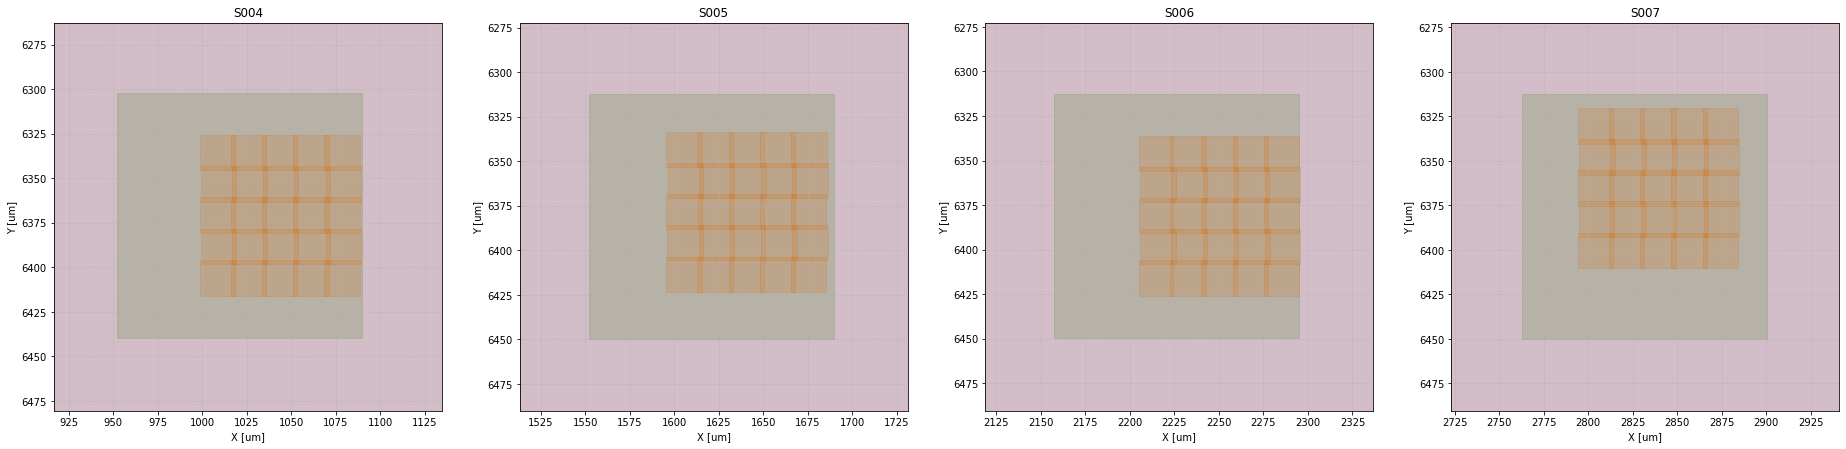

In [14]:
# Set up figure
# -------------
ncols = len(sectionIds)
fig, axes = plt.subplots(ncols=ncols, squeeze=False,
                         figsize=(8*ncols, 8))
axmap = {k: v for k, v in zip(sectionIds, axes.flat)}
cmap = {k: v for k, v in zip(stacks, sns.color_palette(n_colors=len(stacks)))}

# Iterate through layers
for sectionId, layer in df_tiles.groupby('sectionId'):
    # Collect all tiles in each layer to determine bounds
    boxes = []
    # Set axis
    ax = axmap[sectionId]

    # Loop through tilesets within each layer
    for stack, tileset in layer.groupby('stack'):

        # Loop through each tile
        for i, tile in tileset.iterrows():

            # Create `shapely.box`
            dx = tile['width']/2 * tile['pixelsize']/1e3
            dy = tile['height']/2 * tile['pixelsize']/1e3
            minx, maxx = (tile['stageX'] - dx, tile['stageX'] + dx)
            miny, maxy = (tile['stageY'] - dy, tile['stageY'] + dy)
            b = box(minx, miny, maxx, maxy)
            boxes.append(b)
            # Get coordinates of `shapely.box` to plot matplotlib polygon patch
            xy = np.array(b.exterior.xy).T
            p = Polygon(xy, color=cmap[stack], alpha=0.2)
            ax.add_patch(p)

    # Axis aesthetics
    ax.set_title(sectionId)
    ax.set_xlabel('X [um]')
    ax.set_ylabel('Y [um]')
    # Determine bounds
    bounds = np.swapaxes([b.exterior.xy for b in boxes], 1, 2).reshape(-1, 2)
    ax.set_xlim(bounds[:, 0].min(), bounds[:, 0].max())
    ax.set_ylim(bounds[:, 1].min(), bounds[:, 1].max())
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.grid(ls=':')

#### Apply translations

In [15]:
from renderapi.transform import AffineModel

In [16]:
# Iterate through tilesets
for (stack, z), tileset in df_tiles.groupby(['stack', 'z']):

    # Offset by stage position
    # ------------------------
    # Normalize to (0, 0) since Odemis stage position is basically random
    x0 = tileset['stageX'] - tileset['stageX'].min()
    y0 = tileset['stageY'] - tileset['stageY'].min()
    # Divide by pixelsize and flip y axis
    x0 =  x0 / (tileset['pixelsize']/1e3)  # um / (um/px) = px
    y0 = -y0 / (tileset['pixelsize']/1e3)  # um / (um/px) = px
    # Shift y translation up so that it's all positivo
    y0 -= y0.min()

    # Add `render` affine transformations to DataFrame
    # ------------------------------------------------
    # Generate `render` affine transform
    A = [[AffineModel(B0=x, B1=y)] for x, y in zip(x0, y0)]
    # Add to DataFrame
    for j, (i, tile) in enumerate(tileset.iterrows()):
        df_tiles.loc[i, 'tforms'] = [A[j]]

# Preview
df_tiles.groupby('stack').apply(lambda x: x.sample(3))[preview_cols + ['tforms']]

z sectionId               tileId  imageRow  imageCol  \
stack                                                                
AF594    2    6      S006  aaa_insulin-S006...         1         1   
         0    4      S004  aaa_insulin-S004...         1         1   
         1    5      S005  aaa_insulin-S005...         1         1   
EM_himag 27   4      S004  aax_lil_EM-S004-...         2         3   
         66   6      S006  aam_lil_EM-S006-...         4         4   
         33   5      S005  aae_lil_EM-S005-...         6         2   
EM_lomag 106  6      S006  aaa_big_EM-S006-...         1         1   
         104  4      S004  aaa_big_EM-S004-...         1         1   
         105  5      S005  aaa_big_EM-S005-...         1         1   
Hoechst  110  6      S006  aaa_hoechst-S006...         1         1   
         111  7      S007  aaa_hoechst-S007...         1         1   
         108  4      S004  aaa_hoechst-S004...         1         1   

                   stageX       stageY  width  height   pixelsize  \
stack                                                               
AF594    2    2227.808609  6381.567861   2048    2048  106.446054   
         0    1025.598744  6371.521975   2048    2048  106.416630   
         1    1622.072408  6381.077600   2048    2048  106.431569   
EM_himag 27   1025.905000  6405.822000   4096    4096    4.859506   
         66   2250.081000  6380.854000   4096    4096    4.859506   
         33   1605.524000  6343.340000   4096    4096    4.859506   
EM_lomag 106  2226.245000  6381.133000   4096    4096   33.566317   
         104  1021.110000  6371.003000   4096    4096   33.566317   
         105  1621.125000  6381.079000   4096    4096   33.566317   
Hoechst  110  2227.808609  6381.567861   2048    2048  106.446054   
         111  2832.009499  6381.316683   2048    2048  106.467145   
         108  1025.598744  6371.521975   2048    2048  106.416630   

                         acqTime               tforms  
stack                                                  
AF594    2   2019-11-02 16:53:43  [M=[[1.000000,0....  
         0   2019-11-02 15:48:34  [M=[[1.000000,0....  
         1   2019-11-02 16:26:23  [M=[[1.000000,0....  
EM_himag 27  2019-11-03 22:27:16  [M=[[1.000000,0....  
         66  2019-11-04 16:50:26  [M=[[1.000000,0....  
         33  2019-11-04 10:25:19  [M=[[1.000000,0....  
EM_lomag 106 2019-11-02 16:53:46  [M=[[1.000000,0....  
         104 2019-11-02 15:48:38  [M=[[1.000000,0....  
         105 2019-11-02 16:26:26  [M=[[1.000000,0....  
Hoechst  110 2019-11-02 16:53:39  [M=[[1.000000,0....  
         111 2019-11-02 17:36:11  [M=[[1.000000,0....  
         108 2019-11-02 15:48:30  [M=[[1.000000,0....

### `minint`, `maxint` - set min, max intensity levels 

#### FM channels
Sample `N` FM image tiles (per section), take histogram and assign min, max intensity levels according to min and max percentile specified

In [17]:
from tifffile import imread
from skimage import exposure
import matplotlib.ticker as mticker

  0%|          | 0/8 [00:00<?, ?it/s]

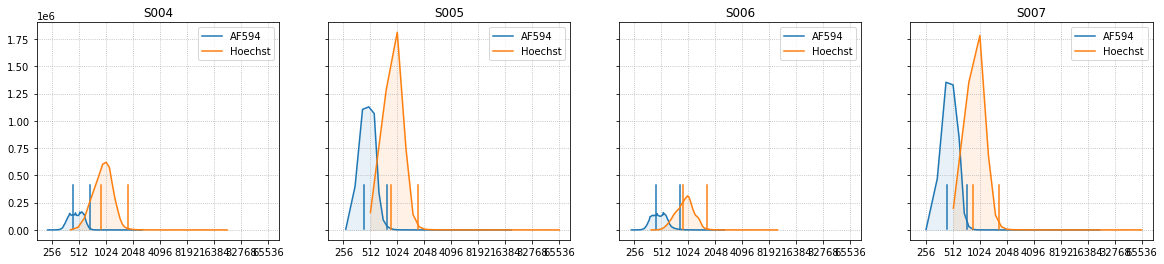

In [18]:
# Parameters
# ----------
N = 10     # Sample size
pct1 = 30  # min %ile
pct2 = 99  # max %ile

# Set up figure
ncols=len(sectionIds)
fig, axes = plt.subplots(ncols=ncols, sharex=True, sharey=True,
                         squeeze=False, figsize=(ncols*5, 4))

# Loop through FM stacks
total = len(stacks_FM) * len(sectionIds)
axmap = {k: v for k, v in zip(sectionIds, axes.flat)}
cmap = {k: v for k, v in zip(stacks_FM, sns.color_palette(n_colors=len(stacks_FM)))}
for i, ((stack, sectionId), tileset) in tqdm(enumerate(df_tiles.loc[df_tiles['stack'].isin(stacks_FM)]\
                                                               .groupby(['stack', 'sectionId'])), total=total):
    # Choose random sample
    fps = tileset.sample(n=min(N, len(tileset)))['imageUrl']

    # Loop through sample image tiles
    images = []
    for fp in fps:

        # Accumulate images
        image = imread(fp.split('.nl')[1])
        images.append(image)

    # Take histograms
    mean = np.mean(images, axis=0)
    hist, bin_centers = exposure.histogram(mean)
    p1, p2 = np.percentile(mean, (pct1, pct2))

    # Set min, max intensity
    df_tiles.loc[(df_tiles['stack'] == stack) &\
                 (df_tiles['sectionId'] == sectionId),
                 ['minint', 'maxint']] = int(p1), 2*int(p1)

    # Plot
    ax = axmap[sectionId]
    color = cmap[stack]
    ax.plot(bin_centers, hist, color=color, label=stack)
    ax.fill_between(bin_centers, 0, hist, color=color, alpha=0.1)
    [ax.axvline(p, ymin=0.05, ymax=0.25, color=color) for p in [p1, p2]]
    # Aesthetics
    ax.set_title(sectionId)
    ax.set_xscale('symlog', base=2)
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.legend()
    ax.grid(ls=':')

#### EM channels
Sample `N` FM image tiles (per section), take histogram and assign min, max intensity levels according to min and max percentile specified

In [19]:
tiles = df_tiles.loc[(df_tiles['sectionId'] == 'S005') &\
                     (df_tiles['imageRow'] == 3)]
tiles

sectionId  imageRow  imageCol    stageX    stageY  pixelsize  z  width  \
44      S005         3         2  1606.134  6395.708   4.859506  5   4096   
45      S005         3         3  1623.689  6395.704   4.859506  5   4096   
46      S005         3         4  1641.261  6395.703   4.859506  5   4096   
47      S005         3         5  1658.826  6395.704   4.859506  5   4096   
48      S005         3         6  1676.102  6395.706   4.859506  5   4096   

    height             imageUrl maskUrl  minint  maxint               tforms  \
44    4096  https://sonic.tn...    None       0   65535  [M=[[1.000000,0....   
45    4096  https://sonic.tn...    None       0   65535  [M=[[1.000000,0....   
46    4096  https://sonic.tn...    None       0   65535  [M=[[1.000000,0....   
47    4096  https://sonic.tn...    None       0   65535  [M=[[1.000000,0....   
48    4096  https://sonic.tn...    None       0   65535  [M=[[1.000000,0....   

                 tileId             acqTime     stack  
44  aap_lil_EM-S005-... 2019-11-04 09:42:25  EM_himag  
45  aaq_lil_EM-S005-... 2019-11-04 09:41:16  EM_himag  
46  aar_lil_EM-S005-... 2019-11-04 09:40:05  EM_himag  
47  aas_lil_EM-S005-... 2019-11-04 09:38:56  EM_himag  
48  aat_lil_EM-S005-... 2019-11-04 09:37:46  EM_himag

In [20]:
image = imread(tiles.loc[46]['imageUrl'].split('.nl')[1])

In [21]:
np.percentile(image, (0.39, 100-0.39))

array([30108., 34505.])

  0%|          | 0/8 [00:00<?, ?it/s]

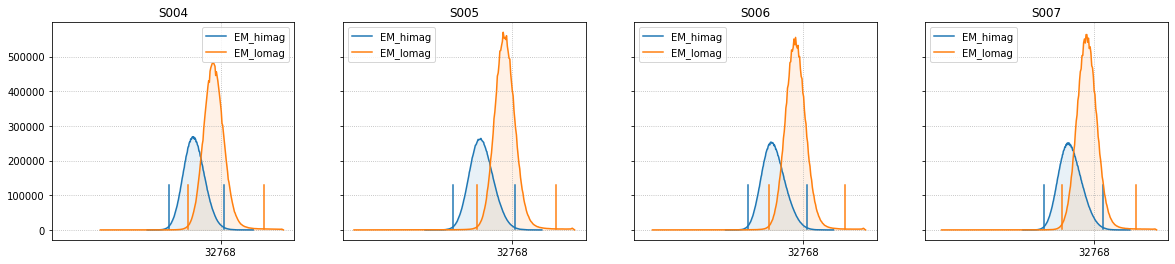

In [22]:
# Parameters
# ----------
N = 5     # Sample size
pct1 = 0.39   # min %ile
pct2 = 100-pct1  # max %ile

# Set up figure
ncols=len(sectionIds)
fig, axes = plt.subplots(ncols=ncols, sharex=True, sharey=True,
                         squeeze=False, figsize=(ncols*5, 4))

# Loop through EM stacks
total = len(stacks_EM) * len(sectionIds)
axmap = {k: v for k, v in zip(sectionIds, axes.flat)}
cmap = {k: v for k, v in zip(stacks_EM, sns.color_palette(n_colors=len(stacks_EM)))}
for i, ((stack, sectionId), tileset) in tqdm(enumerate(df_tiles.loc[df_tiles['stack'].isin(stacks_EM)]\
                                                               .groupby(['stack', 'sectionId'])), total=total):
    # Choose random sample
    fps = tileset.sample(n=min(N, len(tileset)))['imageUrl']

    # Loop through sample image tiles
    images = []
    for fp in fps:

        # Accumulate images
        image = imread(fp.split('.nl')[1])
        images.append(image)

    # Take histograms
    mean = np.mean(images, axis=0)
    hist, bin_centers = exposure.histogram(mean)
    p1, p2 = np.percentile(mean, (pct1, pct2))

    # Set min, max intensity
    df_tiles.loc[(df_tiles['stack'] == stack) &\
                 (df_tiles['sectionId'] == sectionId),
                 ['minint', 'maxint']] = int(p1), int(p2)

    # Plot
    ax = axmap[sectionId]
    color = cmap[stack]
    ax.plot(bin_centers, hist, color=color, label=stack)
    ax.fill_between(bin_centers, 0, hist, color=color, alpha=0.1)
    [ax.axvline(p, ymin=0.05, ymax=0.25, color=color) for p in [p1, p2]]
    # Aesthetics
    ax.set_title(sectionId)
    ax.set_xscale('symlog', base=2)
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.legend()
    ax.grid(ls=':')

#### Optionally overwrite min, max intensity levels

In [23]:
# ranges = {
#     'insulin': (3000, 4000),
#     'hoechst': (1500, 2500),
#     'big_EM': (31900, 33450),
#     'lil_EM': (29800, 33000)
# }

# # Specify stack and sectionId(s)
# sectionIds_ = sectionIds

# df_tiles.loc[(df_tiles['stack'] == 'lil_EM') &\
#              (df_tiles['sectionId'].isin(sectionIds_)),
#              ['minint', 'maxint']] = ranges['lil_EM']

# df_tiles.loc[(df_tiles['stack'] == 'big_EM') &\
#              (df_tiles['sectionId'].isin(sectionIds_)),
#              ['minint', 'maxint']] = ranges['big_EM']

# df_tiles.loc[(df_tiles['stack'] == 'hoechst') &\
#              (df_tiles['sectionId'].isin(sectionIds_)),
#              ['minint', 'maxint']] = ranges['hoechst']

# df_tiles.loc[(df_tiles['stack'] == 'insulin') &\
#              (df_tiles['sectionId'].isin(sectionIds_)),
#              ['minint', 'maxint']] = ranges['insulin']

In [24]:
# Preview
df_tiles.groupby('stack').apply(lambda x: x.sample(3))[preview_cols + ['minint', 'maxint']]

z sectionId               tileId  imageRow  imageCol  \
stack                                                                
AF594    0    4      S004  aaa_insulin-S004...         1         1   
         2    6      S006  aaa_insulin-S006...         1         1   
         3    7      S007  aaa_insulin-S007...         1         1   
EM_himag 43   5      S005  aao_lil_EM-S005-...         4         2   
         74   6      S006  aau_lil_EM-S006-...         2         6   
         73   6      S006  aat_lil_EM-S006-...         3         6   
EM_lomag 104  4      S004  aaa_big_EM-S004-...         1         1   
         105  5      S005  aaa_big_EM-S005-...         1         1   
         107  7      S007  aaa_big_EM-S007-...         1         1   
Hoechst  110  6      S006  aaa_hoechst-S006...         1         1   
         111  7      S007  aaa_hoechst-S007...         1         1   
         109  5      S005  aaa_hoechst-S005...         1         1   

                   stageX       stageY  width  height   pixelsize  \
stack                                                               
AF594    0    1025.598744  6371.521975   2048    2048  106.416630   
         2    2227.808609  6381.567861   2048    2048  106.446054   
         3    2832.009499  6381.316683   2048    2048  106.467145   
EM_himag 43   1605.488000  6378.230000   4096    4096    4.859506   
         74   2284.990000  6416.049000   4096    4096    4.859506   
         73   2285.802000  6398.380000   4096    4096    4.859506   
EM_lomag 104  1021.110000  6371.003000   4096    4096   33.566317   
         105  1621.125000  6381.079000   4096    4096   33.566317   
         107  2831.405000  6381.305000   4096    4096   33.566317   
Hoechst  110  2227.808609  6381.567861   2048    2048  106.446054   
         111  2832.009499  6381.316683   2048    2048  106.467145   
         109  1622.072408  6381.077600   2048    2048  106.431569   

                         acqTime  minint  maxint  
stack                                             
AF594    0   2019-11-02 15:48:34     441     882  
         2   2019-11-02 16:53:43     445     890  
         3   2019-11-02 17:36:15     439     878  
EM_himag 43  2019-11-04 09:48:13   30825   32870  
         74  2019-11-04 16:15:36   30931   32897  
         73  2019-11-04 16:37:39   30931   32897  
EM_lomag 104 2019-11-02 15:48:38   31678   34295  
         105 2019-11-02 16:26:26   31586   34319  
         107 2019-11-02 17:36:18   31681   34238  
Hoechst  110 2019-11-02 16:53:39     884    1768  
         111 2019-11-02 17:36:11     864    1728  
         109 2019-11-02 16:26:19     870    1740

## Import image tiles to `render-ws`
---

### Create stacks

In [25]:
from icatapi.render_pandas import create_stack_from_DataFrame

In [26]:
# Loop through stacks
for stack, df_stack in tqdm(df_tiles.groupby('stack')):

    # Set stack resolution
    Rx = df_stack['pixelsize'].iloc[0]
    Ry = df_stack['pixelsize'].iloc[0]
    Rz = section_thickness

    # Create stacks
    create_stack_from_DataFrame(df=df_stack,
                                name=stack,
                                stackResolutionX=Rx,
                                stackResolutionY=Ry,
                                stackResolutionZ=Rz,
                                render=render);

  0%|          | 0/4 [00:00<?, ?it/s]

Creating tile specifications for AF594...
Importing tile specifications to AF594...
org.janelia.render.client.ImportJsonClient

  Running: /home/catmaid/render/deploy/jdk1.8.0_131/bin/java -cp /home/catmaid/render/render-ws-java-client/target/render-ws-java-client-2.0.1-SNAPSHOT-standalone.jar -Xms2G -Xmx2G -Djava.awt.headless=true -XX:+UseSerialGC org.janelia.render.client.ImportJsonClient --baseDataUrl http://sonic.tnw.tudelft.nl:8080/render-ws/v1 --owner rlane --project pancreas --stack AF594 /tmp/tmpsdizewxp.json


14:03:58.668 [main] INFO  [org.janelia.render.client.ClientRunner] run: entry
14:03:58.818 [main] INFO  [org.janelia.render.client.ImportJsonClient] runClient: entry, parameters={
  "renderWeb" : {
    "baseDataUrl" : "http://sonic.tnw.tudelft.nl:8080/render-ws/v1",
    "owner" : "rlane",
    "project" : "pancreas"
  },
  "tileSpecValidator" : { },
  "stack" : "AF594",
  "tileFiles" : [
    "/tmp/tmpsdizewxp.json"
  ]
}
14:03:59.083 [main] INFO  [org.janelia.render.clien

## Inspect stacks
---

In [27]:
from icatapi.render_pandas import create_stacks_DataFrame
from icatapi.plotting import plot_tile_map, plot_neighborhoods, plot_stacks

### Create project DataFrame

In [28]:
# Project DataFrame
stacks_2_plot = stacks
df_project = create_stacks_DataFrame(stacks=stacks_2_plot,
                                     render=render)
df_project.groupby('stack')\
          .apply(lambda x: x.sample(3))

tileId    z   width  height   minint   maxint  \
stack                                                                      
AF594    2    aaa_insulin-S006...  6.0  2048.0  2048.0    445.0    890.0   
         0    aaa_insulin-S004...  4.0  2048.0  2048.0    441.0    882.0   
         3    aaa_insulin-S007...  7.0  2048.0  2048.0    439.0    878.0   
EM_himag 67   aan_lil_EM-S006-...  6.0  4096.0  4096.0  30931.0  32897.0   
         87   aai_lil_EM-S007-...  7.0  4096.0  4096.0  31112.0  33082.0   
         96   aar_lil_EM-S007-...  7.0  4096.0  4096.0  31112.0  33082.0   
EM_lomag 105  aaa_big_EM-S005-...  5.0  4096.0  4096.0  31586.0  34319.0   
         104  aaa_big_EM-S004-...  4.0  4096.0  4096.0  31678.0  34295.0   
         106  aaa_big_EM-S006-...  6.0  4096.0  4096.0  31639.0  34260.0   
Hoechst  109  aaa_hoechst-S005...  5.0  2048.0  2048.0    870.0   1740.0   
         110  aaa_hoechst-S006...  6.0  2048.0  2048.0    884.0   1768.0   
         111  aaa_hoechst-S007...  7.0  2048.0  2048.0    864.0   1728.0   

                         imageUrl               tforms     stack sectionId  \
stack                                                                        
AF594    2    https://sonic.tn...  [M=[[1.000000,0....     AF594      S006   
         0    https://sonic.tn...  [M=[[1.000000,0....     AF594      S004   
         3    https://sonic.tn...  [M=[[1.000000,0....     AF594      S007   
EM_himag 67   https://sonic.tn...  [M=[[1.000000,0....  EM_himag      S006   
         87   https://sonic.tn...  [M=[[1.000000,0....  EM_himag      S007   
         96   https://sonic.tn...  [M=[[1.000000,0....  EM_himag      S007   
EM_lomag 105  https://sonic.tn...  [M=[[1.000000,0....  EM_lomag      S005   
         104  https://sonic.tn...  [M=[[1.000000,0....  EM_lomag      S004   
         106  https://sonic.tn...  [M=[[1.000000,0....  EM_lomag      S006   
Hoechst  109  https://sonic.tn...  [M=[[1.000000,0....   Hoechst      S005   
         110  https://sonic.tn...  [M=[[1.000000,0....   Hoechst      S006   
         111  https://sonic.tn...  [M=[[1.000000,0....   Hoechst      S007   

              imageRow  imageCol       stageX       stageY  
stack                                                       
AF594    2           1         1  2227.808609  6381.567861  
         0           1         1  1025.598744  6371.521975  
         3           1         1  2832.009499  6381.316683  
EM_himag 67          4         3  2232.626000  6380.863000  
         87          5         5  2857.263000  6347.775000  
         96          3         4  2839.856000  6382.614000  
EM_lomag 105         1         1  1621.125000  6381.079000  
         104         1         1  1021.110000  6371.003000  
         106         1         1  2226.245000  6381.133000  
Hoechst  109         1         1  1622.072408  6381.077600  
         110         1         1  2227.808609  6381.567861  
         111         1         1  2832.009499  6381.316683

### Map out tiles in `render` space

  0%|          | 0/4 [00:00<?, ?it/s]

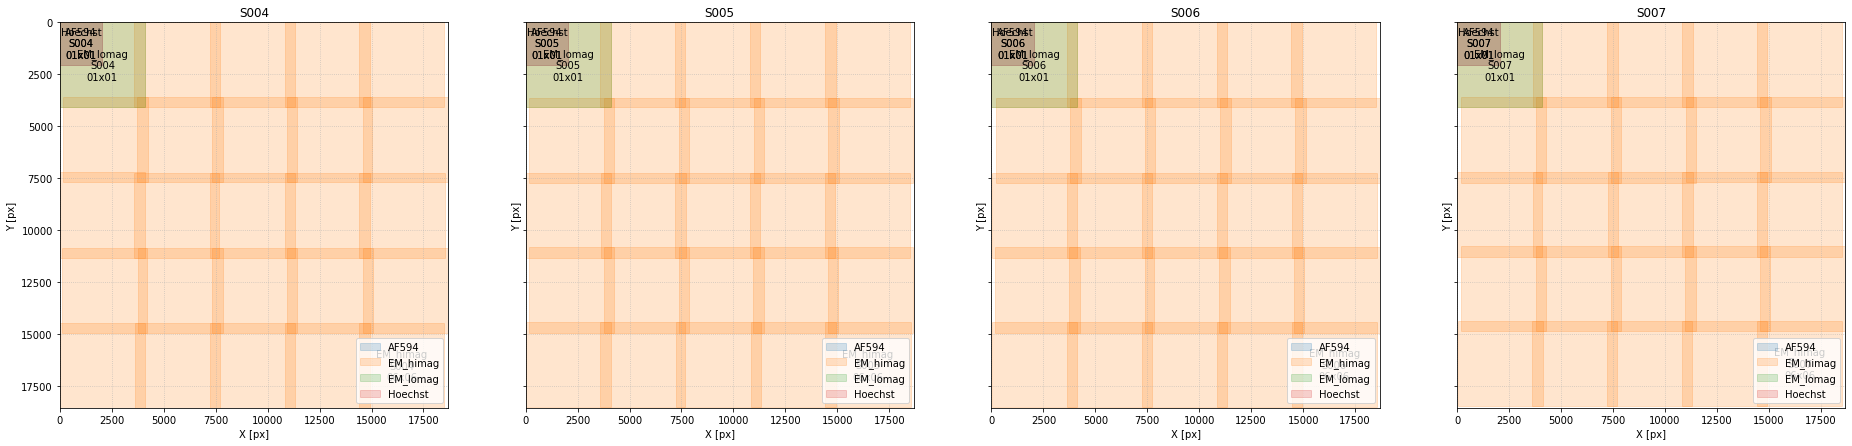

In [29]:
# Plot tile map
plot_tile_map(stacks_2_plot, render=render)

### Render images

#### Sample tile images

  0%|          | 0/16 [00:00<?, ?it/s]

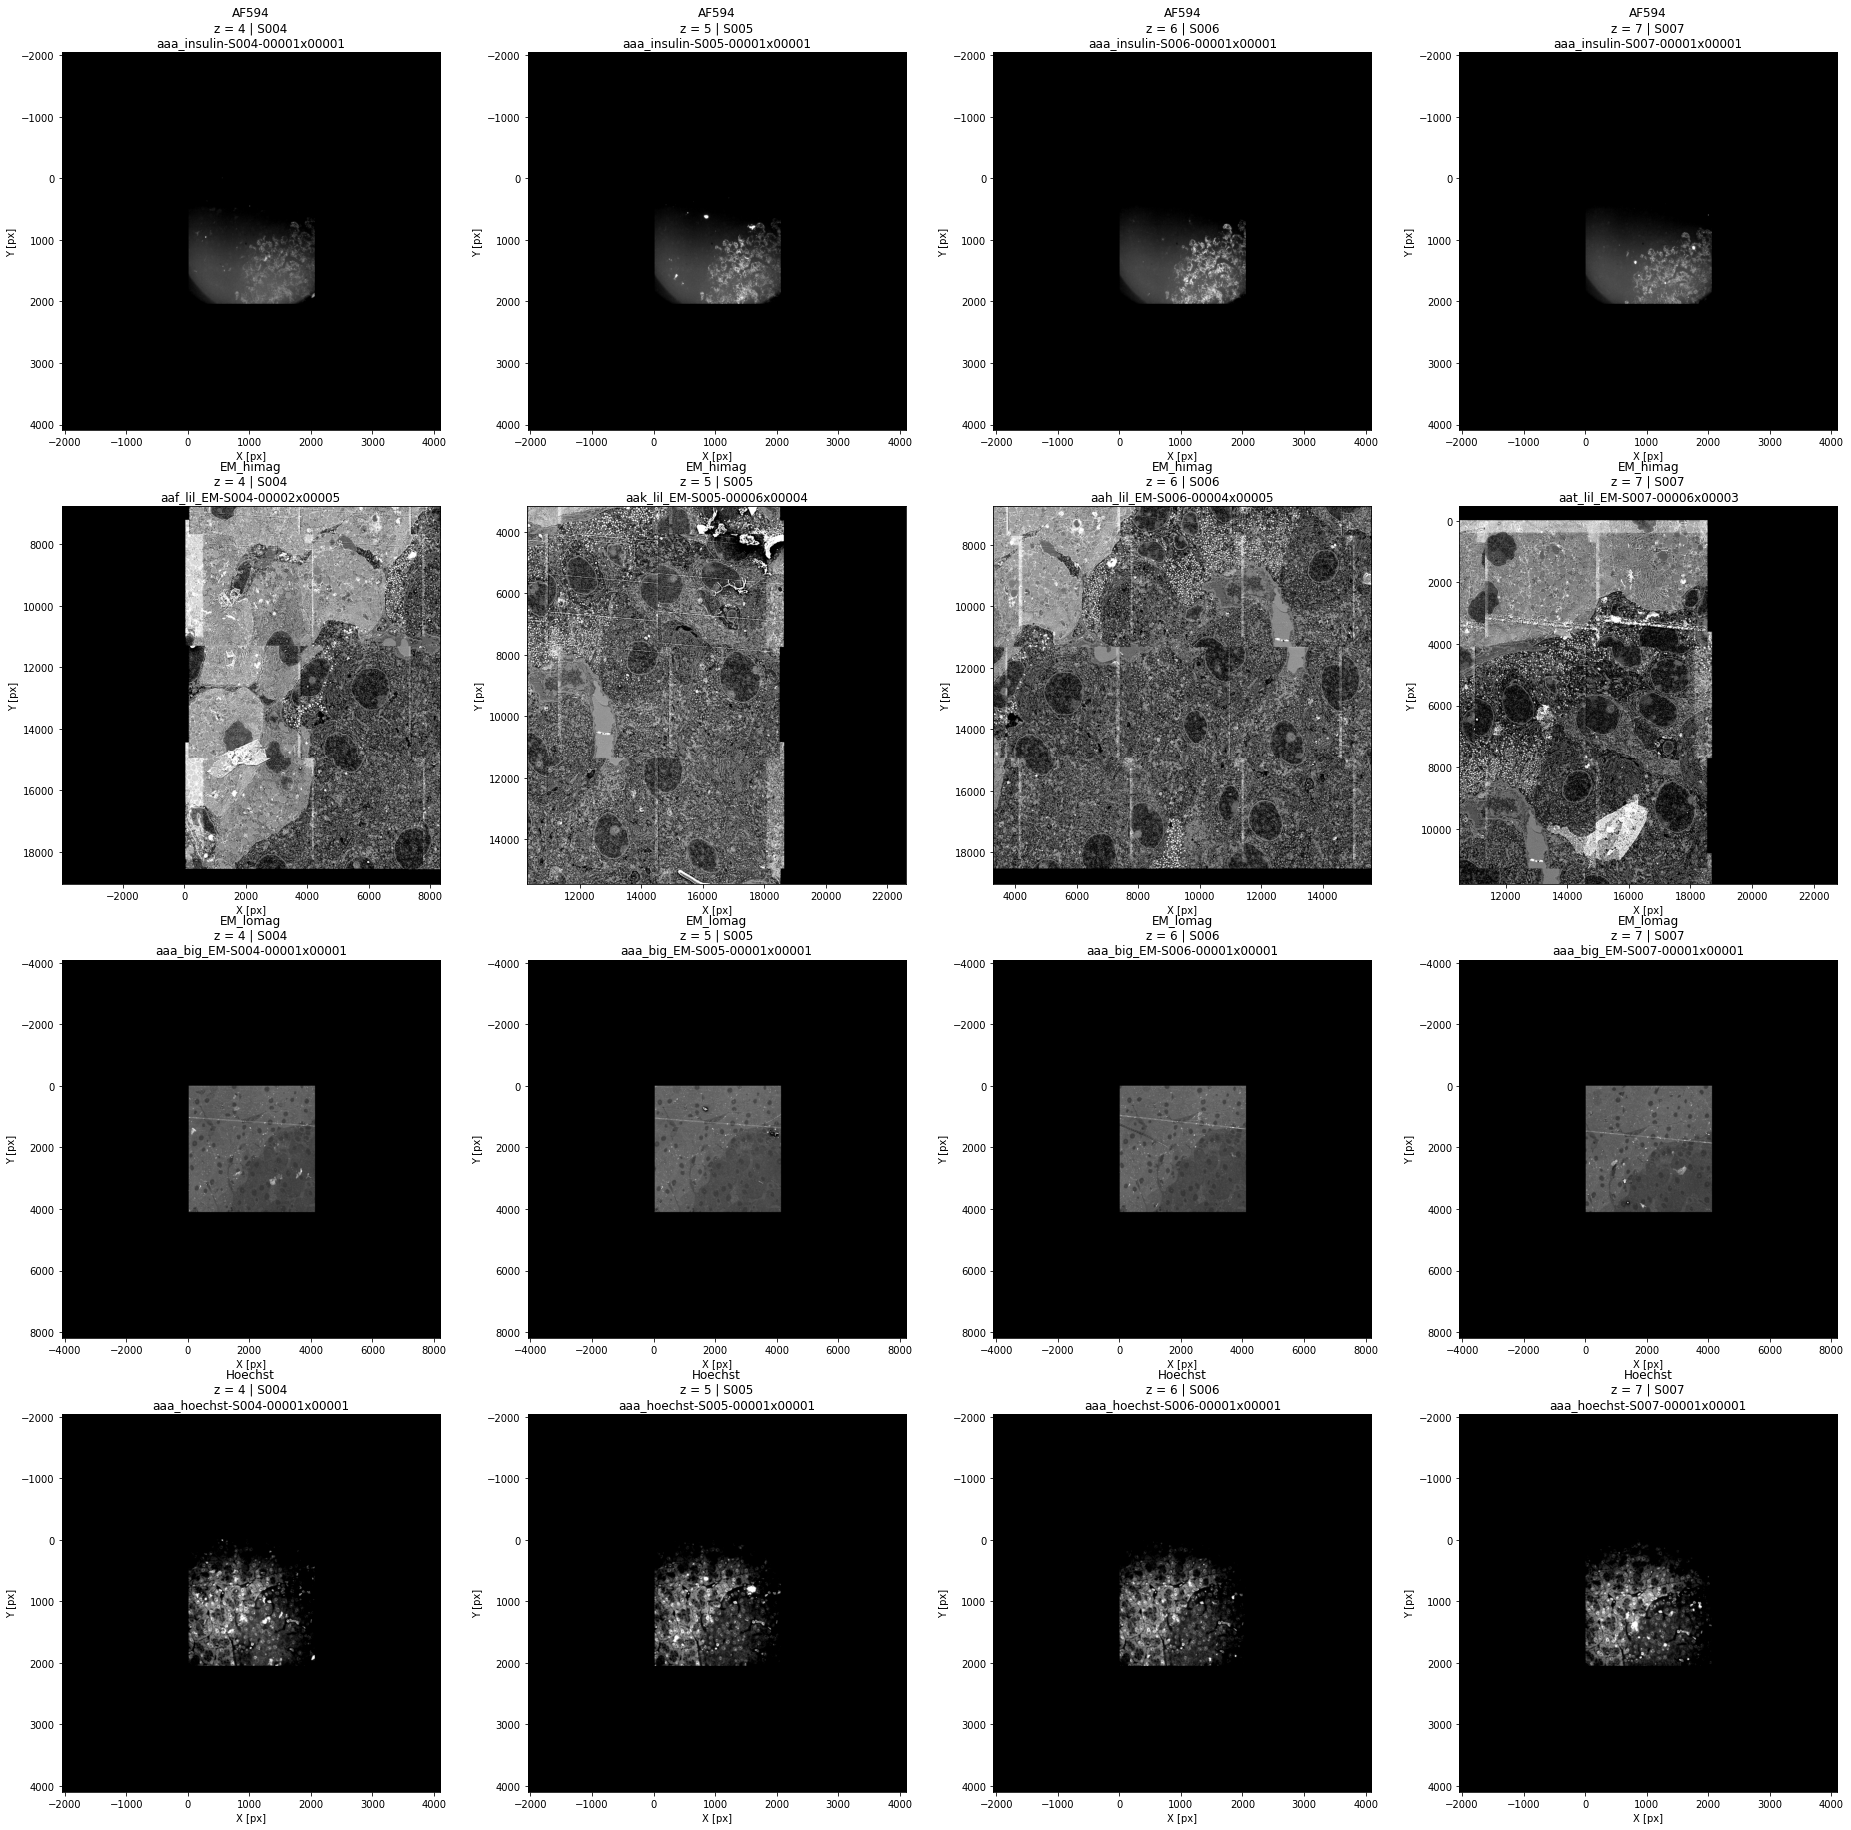

In [30]:
plot_neighborhoods(stacks=stacks_2_plot,
                   render=render)

#### Tileset images

  0%|          | 0/16 [00:00<?, ?it/s]

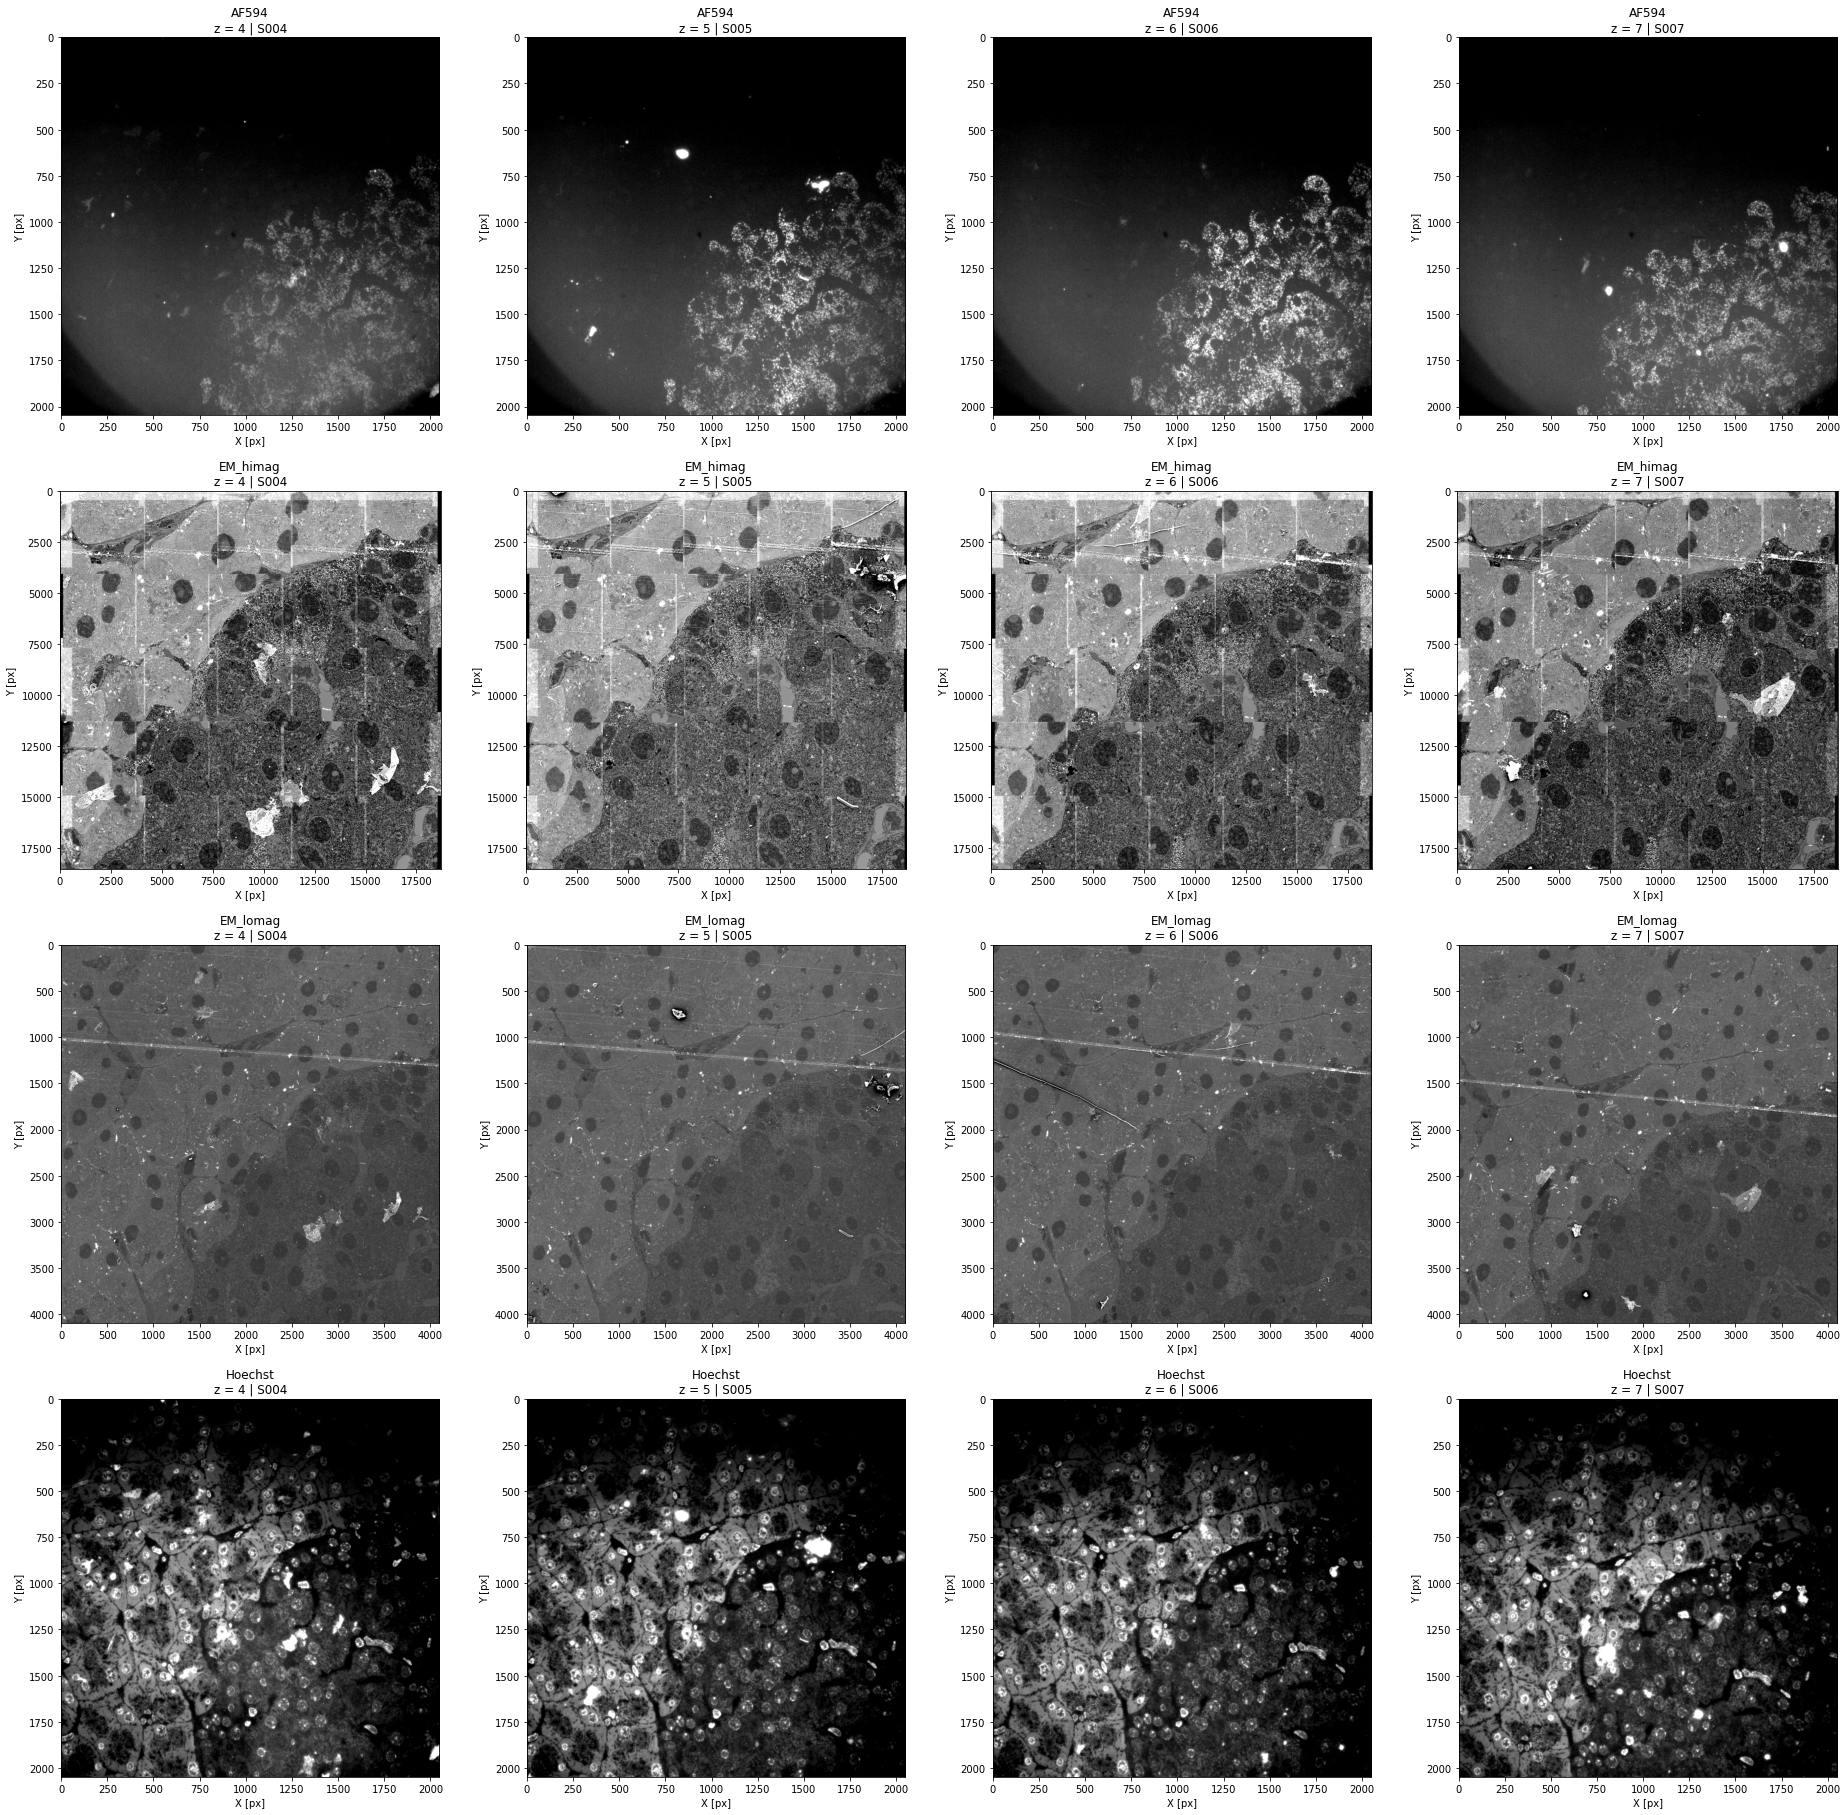

In [31]:
plot_stacks(stacks=stacks_2_plot,
            maxTileSpecsToRender=30,
            render=render)